# 1 Implementing your own Shazam
Shazam is a great application that can tell you the title of a song by listening to a short sample. For this first task, we will implement a simplified copy of this app by dealing with hashing algorithms.

## 1.1 Getting your data!
We will test this part with some query songs which we would like to know the title of (see the file `queries.zip` in the `files` branch of the current repository). To do so we will first need to convert the tracks in the dataset from mp3 format to wav format.

In [1]:
import numpy as np      
import pandas as pd
import matplotlib.pyplot as plt 
import csv
pd.set_option("display.max_columns", None)

In [2]:
import sys
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
from sympy import nextprime
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

In [3]:
N_TRACKS = 1413
HOP_SIZE = 512
OFFSET = 1.0

In [4]:
data_folder = Path("data/mp3s-32k/")
test_data_folder = Path('data/test/')

new_tracks = test_data_folder.glob('*.wav')

mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

In [5]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio


In [6]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## 1.2 Fingerprint hashing

We now want to create a representation of our audio signal that allows us to characterize it with respect to its peaks. Once this process is complete, we can adopt a hashing function to get a fingerprint of each song.

**Utility functions**

In [7]:
def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()
    

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audi
    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks

**Preprocessing**

In [8]:
# To be tuned
DURATION = 30 
THRESHOLD = 0

# audio files
U = []
audio_peaks = []
for idx, audio in enumerate(tqdm(tracks, total=N_TRACKS)):
#     if idx >= 10:
#         break
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
#     print('Track is: ', track) 
#     print('sr is: ', sr)
#     print('onset_env is: ', onset_env)
#     print('peaks is: ', peaks)
#     print('audio is: ', audio)
    U += list(peaks)
    audio_peaks.append((audio, set(peaks)))
#   plot_spectrogram_and_peaks(track, sr, peaks, onset_env)
        
U = set(U)

# load new audios
new_audio_peaks = []
for idx, audio in enumerate(tqdm(new_tracks, total=4)):
    track, sr, onset_env, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE)
    new_audio_peaks.append((audio, set(peaks)))


new_audio_peaks

  0%|          | 0/1413 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

[(PosixPath('data/test/track5.wav'),
  {6,
   41,
   60,
   76,
   111,
   147,
   167,
   182,
   218,
   235,
   252,
   271,
   289,
   307,
   325,
   343,
   361,
   379,
   396,
   432,
   451,
   466,
   502,
   518,
   537,
   556,
   573,
   590,
   608,
   627,
   645,
   680,
   699,
   716,
   751,
   787,
   822,
   842,
   858,
   886,
   929,
   946,
   964,
   983,
   998,
   1017,
   1035,
   1069,
   1088,
   1105,
   1120,
   1141,
   1175,
   1192,
   1210,
   1228,
   1244,
   1259,
   1279}),
 (PosixPath('data/test/track10.wav'),
  {9,
   28,
   41,
   54,
   67,
   87,
   107,
   119,
   167,
   187,
   200,
   221,
   241,
   255,
   268,
   280,
   308,
   328,
   348,
   360,
   380,
   399,
   426,
   439,
   466,
   486,
   505,
   519,
   545,
   559,
   584,
   597,
   624,
   637,
   664,
   678,
   705,
   717,
   745,
   766,
   785,
   798,
   819,
   839,
   865,
   879,
   905,
   927,
   946,
   959,
   986,
   999,
   1025,
   1046,
   1065,
   108

### MinHash

We will now implement a **minhash function** from scratch. After that we will read the dataset sequentially and add it to our **MinHash**. The aim is to make our minhash function to map the same song to the same bins. Then we can also define a threshold to control the accuracy of these matches. 

In [13]:
# REMARK: MinHash is an approximation of  the Jaccard Similarity
def jaccard_similarity(list1, list2):
    """
    :param list1: first set
    :param list2: second set
    :return: the jaccard similarity between the two sets (it's between 0 and 1)
    This function is the function that has to be estimated using the minhashing principle.
    """
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union



In [14]:
# U = list(range(0, 200))
def generate_minhash_fns(u, n):
    """
    :param u: total number of peaks (a, b and c should be less than u)
    :param n: number of hash functions to generate
    :return: an array of hashfunctions (in the form of tuples)
    """
    minhash_functions = []
    c = nextprime(u)
    for _ in range(n):
        a = np.random.randint(u)
        b = np.random.randint(u)
        minhash_functions.append(np.array([a, b, c]))
    return minhash_functions

u = len(U)
n_minhash_fns = 20
minhash_fns = generate_minhash_fns(u, n_minhash_fns)


def perm(x, a, b, c):
    """
    Simulates permutation using modulus 
    :param x: int
    :param a: param (int)
    :param b: param (int)
    :param c: param(int)
    :return: 
    """

    return (a * x + b) % c


def minhash(s, a, b, c):
    """
    :param s: set
    :param a: param
    :param b: param
    :param c: param
    :return: the min hash
    """    
    h = [perm(e, a, b, c) for e in s]
    mh = min(h)
    return mh


def minhash_sign(s):
    """
    :param s: set
    :return: minhash signature with different minhashes
    """
    minhashes = []
    for a, b, c in minhash_fns:
        minhashes.append(minhash(s, a, b, c))
    return minhashes


def minhash_sim(a, b):
    """
    :param a: first set
    :param b: second set
    :return: estimated Jaccard similarity using minhashing
    """

    sign_a = minhash_sign(a)
    sign_b = minhash_sign(b)
    l = len(sign_a)
    t = 0
    for a, b in zip(sign_a, sign_b):
        if a == b:
            t += 1
    return t/l

### Testing the results

In [17]:
jaccard_similarity(new_audio_peaks[0][1], audio_peaks[0][1]) 

thresholds = [0.6, 0.7, 0.9]
for threshold in thresholds:
    results = []
    for new_audio in tqdm(new_audio_peaks):
        max_similarity = -1
        most_similar = ''
        for audio in audio_peaks:
            sim = minhash_sim(new_audio[1], audio[1])
            if sim > max_similarity and sim <= threshold:
                max_similarity = sim
                most_similar = audio[0]
        results.append((new_audio[0], most_similar, max_similarity))
        print('Results for threshold ', threshold, ' is: ', results)
            
    

results = []
for new_audio in tqdm(new_audio_peaks):
    max_similarity = -1
    most_similar = ''
    for audio in audio_peaks:
        sim = minhash_sim(new_audio[1], audio[1])
        if sim > max_similarity:
            max_similarity = sim
            most_similar = audio[0]
    results.append((new_audio[0], most_similar, max_similarity))
            
        
print('Results without thresholding are: ', results)


  0%|          | 0/10 [00:00<?, ?it/s]

Results for threshold  0.6  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2)]
Results for threshold  0.6  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25)]
Results for threshold  0.6  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25), (PosixPath('data/test/track8.wav'), PosixPath('data/mp3s-32k/metallica/Load/05-King_Nothing.wav'), 0.25)]
Results for threshold  0.6  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav')

  0%|          | 0/10 [00:00<?, ?it/s]

Results for threshold  0.7  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2)]
Results for threshold  0.7  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25)]
Results for threshold  0.7  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25), (PosixPath('data/test/track8.wav'), PosixPath('data/mp3s-32k/metallica/Load/05-King_Nothing.wav'), 0.25)]
Results for threshold  0.7  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav')

  0%|          | 0/10 [00:00<?, ?it/s]

Results for threshold  0.9  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2)]
Results for threshold  0.9  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25)]
Results for threshold  0.9  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.2), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav'), 0.25), (PosixPath('data/test/track8.wav'), PosixPath('data/mp3s-32k/metallica/Load/05-King_Nothing.wav'), 0.25)]
Results for threshold  0.9  is:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/garth_brooks/No_Fences_The_Limited_Series_/11-Wolves.wav')

  0%|          | 0/10 [00:00<?, ?it/s]

Results without thresholding are:  [(PosixPath('data/test/track5.wav'), PosixPath('data/mp3s-32k/radiohead/OK_Computer/06-Karma_Police.wav'), 1.0), (PosixPath('data/test/track10.wav'), PosixPath('data/mp3s-32k/steely_dan/Katy_Lied/01-Black_Friday.wav'), 1.0), (PosixPath('data/test/track8.wav'), PosixPath('data/mp3s-32k/green_day/American_Idiot/01-American_Idiot.wav'), 1.0), (PosixPath('data/test/track1.wav'), PosixPath('data/mp3s-32k/aerosmith/Aerosmith/03-Dream_On.wav'), 1.0), (PosixPath('data/test/track3.wav'), PosixPath('data/mp3s-32k/u2/October/07-October.wav'), 1.0), (PosixPath('data/test/track6.wav'), PosixPath('data/mp3s-32k/led_zeppelin/Led_Zeppelin_II/05-Heartbreaker.wav'), 1.0), (PosixPath('data/test/track4.wav'), PosixPath('data/mp3s-32k/beatles/The_White_Album_Disc_1/04-Ob-La-Di_Ob-La-Da.wav'), 1.0), (PosixPath('data/test/track9.wav'), PosixPath('data/mp3s-32k/depeche_mode/Some_Great_Reward/06-Somebody.wav'), 1.0), (PosixPath('data/test/track2.wav'), PosixPath('data/mp3s-32

# 2 Grouping songs together!

The final goal of this part is to group songs into similar genres (without using the feature genre in our K-means anaylsis)

## 2.1  Getting the data and Data Wrangling

We start by reading the datasets we where given.

In [20]:
# REMARK: the execution of this cell can take a few seconds

tracks = pd.read_csv("tracks.csv")
echonest = pd.read_csv("echonest.csv")
features = pd.read_csv("features.csv")

**Traks dataset**

We see that the datasets have many features (e.g. *tracks.csv* has 106574 rows and 53 columns).

In [21]:
print(tracks.shape)
tracks.head()

(106574, 53)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_id,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000,0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000,0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"['instrumentals', 'experimental pop', 'post pu...",NaN,NaN,training,large,256000,0,NaN,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


**Echonest dataset**

In [22]:
print(echonest.shape)
echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

**Features dataset**

In [23]:
print(features.shape)
features.head()

(106574, 519)


,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

### Cleaning of the datasets

Since the `track_id` seems one of the most important features we check wheter there are missing or duplicate values in these columns

In [24]:
print(tracks["track_id"].isnull().any())
print(features["track_id"].isnull().any())
print(echonest["track_id"].isnull().any())

False
False
False


In [25]:
if tracks.track_id.nunique() == len(tracks["track_id"]):
    print("No duplicate track ids")
else:
    print("There are duplicate track ids")

No duplicate track ids


By exploring the datasets, we've seen that some columns have many NaN values and strange entries (e.g. in `album_information`). For this reason we start filling and cleaning  the datasets. The filling part is done following some rules of thumb (see the `fill` function below):
- replace a missing numeric values (as NaN) with the mean of all the numeric values of the same kind
- replace all the NaN strings with a blanc space 

The cleaning part is done by replacing some unpleasant html tags-type-of-strings. For example in the `album_information` column of the `tracks` datasets there are strings like `<p>` we wolud like to eliminate (see the `clean` function below)

In [26]:
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype

In [27]:
def fill(df):
    """
    Input: df, a dataframe
    Output: None
    Remark: the function performs some trasformations on the columns of the dataframe given in input, in particular:
                - if there is a missing numeric value (as NaN) it fills it with an average value
                - if there is a string wich is NaN it replaces it with a blanc space 
    """
    for i in df.columns:
        if df[i].isnull().any() == True:
            if is_numeric_dtype(df[i]) == True:
                df[i] = df[i].fillna(df[i].mean())
            elif is_string_dtype(df[i]) == True:
                    df[i] = df[i].fillna("")

In [28]:
def clean(df):
    """
    Input: df, a dataframe
    Output: None
    Remark: the function replaces every html substring in the dataframe's columns with a blanc space
    """
    for i in df.columns:
            if is_string_dtype(df[i]) == True:
                    df[i] = df[i].str.replace(r'<[^<>]*>', '', regex=True)

In [29]:
# copy the datasets in order to keep the original files unchanged
cleaned_tracks = tracks.copy()
cleaned_echonest = echonest.copy()
cleaned_features = features.copy()

In [30]:
fill(cleaned_tracks)

In [31]:
clean(cleaned_tracks)

**Remark .** In 2.2 we will apply PCA and to do so we will need to process and transform the datasets (standardization). In the this phase we will rescale the numeric columns. Since `album_id` and `artist_id` are a fixed number that corresponds to an album and an artist we don't want to change them in the process. This is why we will momentarely drop these features.  

In [32]:
cleaned_tracks = cleaned_tracks.drop(["album_id", "artist_id"], axis = 1)

In [33]:
print(cleaned_tracks.shape)
cleaned_tracks.head()

(106574, 51)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
0,2,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,,,"A Way Of Life, A Collective of Hip-Hop from NJ...",0,2008-11-26 01:42:32,9,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,,training,small,256000,0,,2008-11-26 01:48:12,2008-11-26 00:00:00,168,2,Hip-Hop,[21],[21],,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,,3,,[],Food
1,3,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,,,"A Way Of Life, A Collective of Hip-Hop from NJ...",0,2008-11-26 01:42:32,9,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,,training,medium,256000,0,,2008-11-26 01:48:14,2008-11-26 00:00:00,237,1,Hip-Hop,[21],[21],,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,,4,,[],Electric Ave
2,5,0,2008-11-26 01:44:45,2009-01-05 00:00:00,,4,,6073,,[],AWOL - A Way Of Life,7,Album,2006-01-01 00:00:00,,,"A Way Of Life, A Collective of Hip-Hop from NJ...",0,2008-11-26 01:42:32,9,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,,training,small,256000,0,,2008-11-26 01:48:20,2008-11-26 00:00:00,206,6,Hip-Hop,[21],[21],,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,,6,,[],This World
3,10,0,2008-11-26 01:45:08,2008-02-06 00:00:00,,4,,47632,,[],Constant Hitmaker,2,Album,,,"Mexican Summer, Richie Records, Woodsist, Skul...","""Philly's Constant Hitmaker"" Kurt Vile plays p...",3,2008-11-26 01:42:55,74,39.901626,,-38.668642,"Kurt Vile, the Violators",Kurt Vile,,"['philly', 'kurt vile']",http://kurtvile.com,,training,small,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161,178,Pop,[10],[10],,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,,1,,[],Freeway
4,20,0,2008-11-26 01:45:05,2009-01-06 00:00:00,,2,"""spiritual songs"" from Nicky Cook",2710,,[],Niris,13,Album,1990-01-01 00:00:00,2011-01-01 00:00:00,,"Songs written by: Nicky Cook\nVOCALS, CAJON AN...",2,2008-11-26 01:42:52,10,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,,"['instrumentals', 'experimental pop', 'post pu...",,,training,large,256000,0,,2008-11-26 01:48:56,2008-01-01 00:00:00,311,0,,"[76, 103]","[17, 10, 76, 103]",,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,,3,,[],Spiritual Level


We now will fill and clean the `echonest` dataset.

In [34]:
fill(cleaned_echonest)

In [35]:
clean(cleaned_echonest)

In [36]:
print(cleaned_echonest.shape)
cleaned_echonest.head()

(13129, 250)


,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_album_date,metadata_album_name,metadata_artist_latitude,metadata_artist_location,metadata_artist_longitude,metadata_artist_name,metadata_release,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,temporal_features_026,temporal_features_027,temporal_features_028,temporal_features_029,temporal_features_030,temporal_features_031,temporal_features_032,temporal_features_033,temporal_features_034,temporal_features_035,temporal_features_036,temporal_features_037,temporal_features_038,temporal_features_039,temporal_features_040,temporal_features_041,temporal_features_042,temporal_features_043,temporal_features_044,temporal_features_045,temporal_features_046,temporal_features_047,temporal_features_048,temporal_features_049,temporal_features_050,temporal_features_051,temporal_features_052,temporal_features_053,temporal_features_054,temporal_features_055,temporal_features_056,temporal_features_057,temporal_features_058,temporal_features_059,temporal_features_060,temporal_features_061,temporal_features_062,temporal_features_063,temporal_features_064,temporal_features_065,temporal_features_066,temporal_features_067,temporal_features_068,temporal_features_069,temporal_features_070,temporal_features_071,temporal_features_072,temporal_features_073,temporal_features_074,temporal_features_075,temporal_features_076,temporal_features_077,temporal_features_078,temporal_features_079,temporal_features_080,temporal_features_081,temporal_features_082,temporal_features_083,temporal_features_084,temporal_features_085,temporal_features_086,temporal_features_087,temporal_features_088,temporal_features_089,temporal_features_090,temporal_features_091,temporal_features_092,temporal_features_093,temporal_features_094,temporal_features_095,temporal_features_096,temporal_features_097,temporal_features_098,temporal_features_099,temporal_features_100,temporal_features_101,temporal_features_102,temporal_features_103,temporal_features_104,temporal_features_105,temporal_features_106,temporal_features_107,temporal_features_108,temporal_features_109,temporal_features_110,temporal_features_111,temporal_features_112,temporal_features_113,temporal_features_114,temporal_features_115,temporal_features_116,temporal_features_117,temporal_features_118,temporal_features_119,temporal_features_120,temporal_features_121,temporal_features_122,temporal_features_123,temporal_features_124,temporal_features_125,temporal_features_126,temporal_features_127,temporal_features_128,temporal_features_129,temporal_features_130,temporal_features_131,temporal_features_132,temporal_features_133,temporal_features_134,temporal_features_135,temporal_features_136,temporal_features_137,temporal_features_138,temporal_features_139,temporal_features_140,temporal_features_141,temporal_features_142,temporal_features_143,temporal_features_144,temporal_features_145,temporal_features_146,temporal_features_147,temporal_features_148,temporal_features_149,temporal_features_150,tempor

**Remark .** We've decided to drop some columns to reduce the size of the `echonest` dataset. For example we believe that in our analysis `metadata_album_date`, `metadata_album_name` ecc... are not relevant, in particular those features are most of the time empty.

In [37]:
cleaned_echonest = cleaned_echonest.drop(["metadata_album_date", "metadata_album_name"], axis = 1)

We now will fill and clean the `features` dataset.

In [38]:
fill(cleaned_features)

In [39]:
clean(cleaned_features)

In [40]:
cleaned_features.head()

,track_id,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_stft_max_11,chroma_stft_max_12,chroma_stft_mean_01,chroma_stft_mean_02,chroma_stft_mean_03,chroma_stft_mean_04,chroma_stft_mean_05,chroma_stft_mean_06,chroma

### Merge of the datasets

As we saw with the exploratory data analysis, the `echonest` dataset has 13.129 unique `track_id`s, while the `features` and `tracks` dataset have 106.574 unique `tracks_id`. The datasets are related to each other:
- `echonest` has some information about the audio features, metadata, ranks ecc...
- `features` contains many numerical entries that should uniquely characterize the tracks.
- `tracks` contains many informations on the album, the artist and the track.

Since the datasets have `track_id` in common, we decided to use it as a key to join the datasets. In particular we will merge the datasets w.r.t. `track_id` keeping the `echonest` dataset's rows ($\sim 13000$ rows). We than fill and clean the dataset as it was done before.

In [41]:
# merge tracks and echonest w.r.t. track_id
first_merge = cleaned_tracks.merge(cleaned_features, on = "track_id")
dataset = first_merge.merge(cleaned_echonest, on = "track_id")

In [42]:
fill(dataset)

In [43]:
clean(dataset)

In [44]:
print(dataset.shape)
dataset.head()

(13129, 816)


,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_information,album_listens,album_producer,album_tags,album_title,album_tracks,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_comments,artist_date_created,artist_favorites,artist_latitude,artist_location,artist_longitude,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_bit_rate,track_comments,track_composer,track_date_created,track_date_recorded,track_duration,track_favorites,track_genre_top,track_genres,track_genres_all,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cq

## 2.2 Choose your features (variables)!
We have plenty of features to work with (> 800 columns). So, we will need to find a way to reduce the dimensionality. We will use **PCA** (Principal Component Analysis) for **Dimensionality Reduction**. 

**Disclamair**. We've gained many insight from https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad. 

In [45]:
from sklearn.decomposition import PCA
from sklearn import preprocessing

Since we would like to apply PCA, first we need to select all the numeric features frome the dataset(s).

In [46]:
processed_dataset = dataset.select_dtypes([np.number])

In [47]:
print(processed_dataset.shape)
processed_dataset.head()

(13129, 778)


,track_id,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_m

Now we "standardize" the features by removing the mean and scaling to unit variance. This transformations can be done using `sklearn preprocessing`, in particular using `sklearn.preprocessing.StandardScaler`.

**Remark .** In this preprocessing part we will ignore some features (e.g. `track_id`). Indeed it isn't good to change some fixed features that are related to the ordeting of the songs or the id of the tracks and the albums. Recall that we have already ignored `album_id` and `artist_id` in 2.1. At the end of this processing part we will restore some of the columns we have previously ignored.

In [48]:
# this dataset can be also be used to carry out some other dimensionality reduction
# we will use it for the PCA

df = processed_dataset

In [49]:
scaler = preprocessing.StandardScaler()

# processed dataset without trak_id as a feature
temp_df = pd.DataFrame(scaler.fit_transform(df[df.columns[1:]].values), columns = df.columns[1:])

In [50]:
#print(final_df.shape)
temp_df.head()

,album_comments,album_favorites,album_listens,album_tracks,artist_comments,artist_favorites,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chr

**Remark.** In this temporary dataframe there are many columns that we will never use in our future analysis, that is why we drop them. Moreover, by reducing the number of columns we will then have a more accurate clustering (cfr. 2.4) while reducing the number of components in the PCA. If the following columns where not to be dropped the neede components to retain more then 70% of the variance would be 75 instead of 70 and the successive clustering would be less accurate.

In [51]:
temp_df = temp_df.drop(["metadata_artist_longitude", 
                            "ranks_artist_discovery_rank",
                            "ranks_artist_familiarity_rank",
                            "ranks_artist_hotttnesss_rank",
                            "ranks_song_currency_rank",
                            "ranks_song_hotttnesss_rank",
                            "artist_comments","artist_favorites",
                            "artist_latitude","track_number"],
                           axis = 1)

In [52]:
print(temp_df.shape)
temp_df.head()

(13129, 767)


,album_comments,album_favorites,album_listens,album_tracks,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,chroma_cens_kurtosis_11,chroma_cens_kurtosis_12,chroma_cens_max_01,chroma_cens_max_02,chroma_cens_max_03,chroma_cens_max_04,chroma_cens_max_05,chroma_cens_max_06,chroma_cens_max_07,chroma_cens_max_08,chroma_cens_max_09,chroma_cens_max_10,chroma_cens_max_11,chroma_cens_max_12,chroma_cens_mean_01,chroma_cens_mean_02,chroma_cens_mean_03,chroma_cens_mean_04,chroma_cens_mean_05,chroma_cens_mean_06,chroma_cens_mean_07,chroma_cens_mean_08,chroma_cens_mean_09,chroma_cens_mean_10,chroma_cens_mean_11,chroma_cens_mean_12,chroma_cens_median_01,chroma_cens_median_02,chroma_cens_median_03,chroma_cens_median_04,chroma_cens_median_05,chroma_cens_median_06,chroma_cens_median_07,chroma_cens_median_08,chroma_cens_median_09,chroma_cens_median_10,chroma_cens_median_11,chroma_cens_median_12,chroma_cens_min_01,chroma_cens_min_02,chroma_cens_min_03,chroma_cens_min_04,chroma_cens_min_05,chroma_cens_min_06,chroma_cens_min_07,chroma_cens_min_08,chroma_cens_min_09,chroma_cens_min_10,chroma_cens_min_11,chroma_cens_min_12,chroma_cens_skew_01,chroma_cens_skew_02,chroma_cens_skew_03,chroma_cens_skew_04,chroma_cens_skew_05,chroma_cens_skew_06,chroma_cens_skew_07,chroma_cens_skew_08,chroma_cens_skew_09,chroma_cens_skew_10,chroma_cens_skew_11,chroma_cens_skew_12,chroma_cens_std_01,chroma_cens_std_02,chroma_cens_std_03,chroma_cens_std_04,chroma_cens_std_05,chroma_cens_std_06,chroma_cens_std_07,chroma_cens_std_08,chroma_cens_std_09,chroma_cens_std_10,chroma_cens_std_11,chroma_cens_std_12,chroma_cqt_kurtosis_01,chroma_cqt_kurtosis_02,chroma_cqt_kurtosis_03,chroma_cqt_kurtosis_04,chroma_cqt_kurtosis_05,chroma_cqt_kurtosis_06,chroma_cqt_kurtosis_07,chroma_cqt_kurtosis_08,chroma_cqt_kurtosis_09,chroma_cqt_kurtosis_10,chroma_cqt_kurtosis_11,chroma_cqt_kurtosis_12,chroma_cqt_max_01,chroma_cqt_max_02,chroma_cqt_max_03,chroma_cqt_max_04,chroma_cqt_max_05,chroma_cqt_max_06,chroma_cqt_max_07,chroma_cqt_max_08,chroma_cqt_max_09,chroma_cqt_max_10,chroma_cqt_max_11,chroma_cqt_max_12,chroma_cqt_mean_01,chroma_cqt_mean_02,chroma_cqt_mean_03,chroma_cqt_mean_04,chroma_cqt_mean_05,chroma_cqt_mean_06,chroma_cqt_mean_07,chroma_cqt_mean_08,chroma_cqt_mean_09,chroma_cqt_mean_10,chroma_cqt_mean_11,chroma_cqt_mean_12,chroma_cqt_median_01,chroma_cqt_median_02,chroma_cqt_median_03,chroma_cqt_median_04,chroma_cqt_median_05,chroma_cqt_median_06,chroma_cqt_median_07,chroma_cqt_median_08,chroma_cqt_median_09,chroma_cqt_median_10,chroma_cqt_median_11,chroma_cqt_median_12,chroma_cqt_min_01,chroma_cqt_min_02,chroma_cqt_min_03,chroma_cqt_min_04,chroma_cqt_min_05,chroma_cqt_min_06,chroma_cqt_min_07,chroma_cqt_min_08,chroma_cqt_min_09,chroma_cqt_min_10,chroma_cqt_min_11,chroma_cqt_min_12,chroma_cqt_skew_01,chroma_cqt_skew_02,chroma_cqt_skew_03,chroma_cqt_skew_04,chroma_cqt_skew_05,chroma_cqt_skew_06,chroma_cqt_skew_07,chroma_cqt_skew_08,chroma_cqt_skew_09,chroma_cqt_skew_10,chroma_cqt_skew_11,chroma_cqt_skew_12,chroma_cqt_std_01,chroma_cqt_std_02,chroma_cqt_std_03,chroma_cqt_std_04,chroma_cqt_std_05,chroma_cqt_std_06,chroma_cqt_std_07,chroma_cqt_std_08,chroma_cqt_std_09,chroma_cqt_std_10,chroma_cqt_std_11,chroma_cqt_std_12,chroma_stft_kurtosis_01,chroma_stft_kurtosis_02,chroma_stft_kurtosis_03,chroma_stft_kurtosis_04,chroma_stft_kurtosis_05,chroma_stft_kurtosis_06,chroma_stft_kurtosis_07,chroma_stft_kurtosis_08,chroma_stft_kurtosis_09,chroma_stft_kurtosis_10,chroma_stft_kurtosis_11,chroma_stft_kurtosis_12,chroma_stft_max_01,chroma_stft_max_02,chroma_stft_max_03,chroma_stft_max_04,chroma_stft_max_05,chroma_stft_max_06,chroma_stft_max_07,chroma_stft_max_08,chroma_stft_max_09,chroma_stft_max_10,chroma_s

### PCA with 70 components in order to have > 70% of the total variance 
We decided to keep this number of features because it is both one order of magnitude less than the original number of features and a big enough to keep a good percentage of the original variance.

In [53]:
# dimensionality reduction
pca = PCA(n_components=70)
df_pca = pca.fit_transform(temp_df)

# retained total variance
print(sum(pca.explained_variance_ratio_))

0.7112646302275722


In [54]:
# convert the result of PCA into a pandas dataframe
# this reduced dataset misses some important features, e.g. track's duration or language
# some of those features will be restored in the final_reduced_dataset below
final_df_pca = pd.DataFrame(df_pca, columns = ['Feature_%i' % i for i in range(70)])

In [55]:
print(final_df_pca.shape)
final_df_pca.head()

(13129, 70)


,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69
0,3.072119,-2.813221,-5.725668,4.304132,3.132022,2.035440,6.762814,-0.911985,-2.241416,4.289450,-4.922346,1.591437,-4.127119,5.366357,-0.418826,2.156308,-1.021449,-0.885456,1.858664,0.471522,-2.180434,-0.666800,-2.008849,1.657796,0.323524,-3.121823,-0.582617,0.477295,3.375484,-1.054536,0.631447,1.364209,0.019399,-1.381248,-0.183418,0.876504,0.868720,-1.519634,3.055780,-0.406429,0.141762,-3.413881,0.158314,-1.296973,-0.631775,-1.301991,0.879866,2.289361,1.309291,-0.732240,0.809130,0.150777,1.261749,-0.040736,-1.524833,-0.880712,-1.639447,-0.116741,-0.235137,-0.651479,-2.199347,0.752734,0.833377,0.088318,0.927609,0.389138,0.317811,-0.641747,0.087874,-0.306678
1,5.772561,-5.407181,-5.294061,-1.584266,-3.638395,2.654533,-1.537542,5.905883,-0.147142,4.196322,-2.232328,2.496246,-0.802963,3.845890,1.908553,1.201517,-2.027632,-3.927108,0.030639,1.718998,0.458588,-1.333962,-0.105748,3.662689,0.411962,-1.220433,0.989977,-0.739263,1.316735,-0.935997,1.707657,0.584221,-0.540954,-0.463644,-1.199781,1.782897,-1.558571,-0.742920,2.120738,3.094388,-2.194779,-0.418205,-0.814308,-0.880816,-1.421191,-2.758551,1.798212,0.029270,0.966376,0.213901,-1.423308,-0.436824,0.664666,-0.804811,-0.126009,-2.558758,-1.167925,0.091903,-1.238039,-0.270714,-0.415459,-0.370817,0.530109,-0.588128,1.321617,-0.548403,-0.155986,0.245963,-1.476685,1.057215
2,2.649641,-4.158976,-4.567940,-0.047132,-2.858061,2.094867,-1.279897,-0.327407,-0.115413,1.768117,-2.125721,3.173056,-3.124092,2.647477,0.097051,2.158555,-0.692991,-3.070376,2.254979,-1.802855,-2.939126,-1.284946,2.110134,2.939396,-0.549716,-2.196504,1.220935,-0.531148,0.253878,-0.874533,0.982520,-2.527932,1.397752,-0.746457,1.847429,-0.318288,0.145770,-1.600376,1.050530,2.531595,-1.355892,-1.505836,-0.083189,-0.862762,-0.887738,1.131726,1.050763,0.842503,-0.474756,-1.849124,0.737532,-0.466404,2.471529,-1.416131,-2.087690,-2.746890,-1.430543,-2.297307,0.641391,0.085349,-1.280372,-1.257064,1.136452,-1.660398,-1.166402,0.516734,-0.403789,-0.363024,0.168949,2.003296
3,9.115670,3.774618,-5.525645,0.761816,-1.352966,0.598744,-1.806204,4.104496,-0.543390,4.885488,-1.975667,6.558287,1.826454,0.000408,-1.482159,-4.445160,0.006109,-2.864430,2.662812,-1.971283,-2.381675,4.235330,-2.302619,0.090118,2.357771,-1.925538,-1.395706,0.907721,-0.382035,5.491218,-1.060498,4.300053,1.953275,4.245409,3.511838,0.108911,-5.528486,-2.372455,0.261941,1.286052,-0.261019,-2.171099,0.499492,0.472658,-1.856357,-1.366843,1.393731,0.736369,-1.678914,-3.209897,0.216900,2.274608,0.075130,1.252053,0.643083,-0.263949,-0.303804,0.997509,-0.946655,-0.178919,-1.164605,0.661905,-0.694683,-1.053222,2.142534,0.014732,-1.902633,2.422163,-0.666289,1.923754
4,1.304113,-9.446307,-4.280819,0.727942,-3.844975,-1.236656,-2.937631,-2.198282,-0.519997,2.524127,-0.571457,1.422137,-1.259725,1.103723,-0.960878,1.950518,2.180632,-1.753235,1.130802,2.053756,0.080862,-2.421076,0.178947,0.203299,-1.055265,-2.936424,1.752632,0.032424,1.575963,1.431831,-0.644605,-0.031911,0.994839,-2.478709,0.831314,0.059904,0.206688,-1.083684,-0.915856,2.213286,0.532936,-1.598853,-0.368293,-0.512312,0.330484,-1.441935,0.486125,-0.079722,-0.615031,-0.831753,-0.006297,0.288853,-0.076870,0.855943,-0.370697,0.184810,-2.250909,0.007876,-2.547213,

### Interpretation of the results
By plotting the contribution of each components to the retained total variance we see that the first features contribute the most to the retained variance. We se, for example, that `Feature_0` contributes to the 10.6% of the total variance and uccessive features then contribute lesser and lesser.

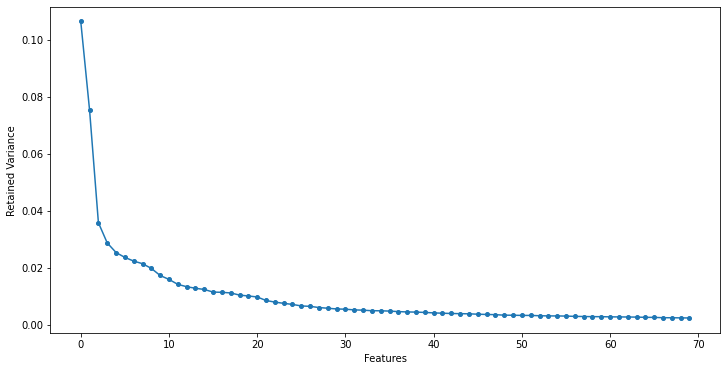

In [56]:
fig = plt.figure(figsize=(12,6))
plt.plot(pca.explained_variance_ratio_, marker=".", markersize=8)
plt.ylabel('Retained Variance')
plt.xlabel('Features')
plt.show()

In [57]:
pca.explained_variance_ratio_

array([0.10647465, 0.07530308, 0.03581398, 0.02870888, 0.02534384,
       0.02362203, 0.02233597, 0.02141547, 0.01976614, 0.01727438,
       0.01589845, 0.01416051, 0.01334082, 0.01278223, 0.01236915,
       0.01144817, 0.011363  , 0.01114483, 0.01038998, 0.01008244,
       0.00973131, 0.00849521, 0.00792713, 0.00749675, 0.00711599,
       0.0065776 , 0.00644028, 0.00601827, 0.0057746 , 0.00552072,
       0.00543779, 0.00518869, 0.00509955, 0.0049002 , 0.00488045,
       0.00477116, 0.00458892, 0.00447316, 0.00441844, 0.00430034,
       0.00413965, 0.00402711, 0.00393082, 0.00386829, 0.00381307,
       0.00368102, 0.00359142, 0.00351409, 0.0033408 , 0.00331598,
       0.00325696, 0.00324837, 0.00314414, 0.00308113, 0.00307019,
       0.00302066, 0.00291686, 0.00286824, 0.00281793, 0.00280996,
       0.00275114, 0.00272635, 0.00269794, 0.00266197, 0.00257903,
       0.00256682, 0.00244611, 0.00243701, 0.0023909 , 0.0023561 ])

The following plot shows that by increasing the number of retained features the total retained variance increases. It is interesting to note that by keeping just 30 features we would have retained more than the 50% of the total variance. This suggests that many initial features where redundant.

In [58]:
var = np.cumsum(np.round(pca.explained_variance_ratio_,decimals = 3)*100)

In [59]:
var

array([10.6, 18.1, 21.7, 24.6, 27.1, 29.5, 31.7, 33.8, 35.8, 37.5, 39.1,
       40.5, 41.8, 43.1, 44.3, 45.4, 46.5, 47.6, 48.6, 49.6, 50.6, 51.4,
       52.2, 52.9, 53.6, 54.3, 54.9, 55.5, 56.1, 56.7, 57.2, 57.7, 58.2,
       58.7, 59.2, 59.7, 60.2, 60.6, 61. , 61.4, 61.8, 62.2, 62.6, 63. ,
       63.4, 63.8, 64.2, 64.6, 64.9, 65.2, 65.5, 65.8, 66.1, 66.4, 66.7,
       67. , 67.3, 67.6, 67.9, 68.2, 68.5, 68.8, 69.1, 69.4, 69.7, 70. ,
       70.2, 70.4, 70.6, 70.8])

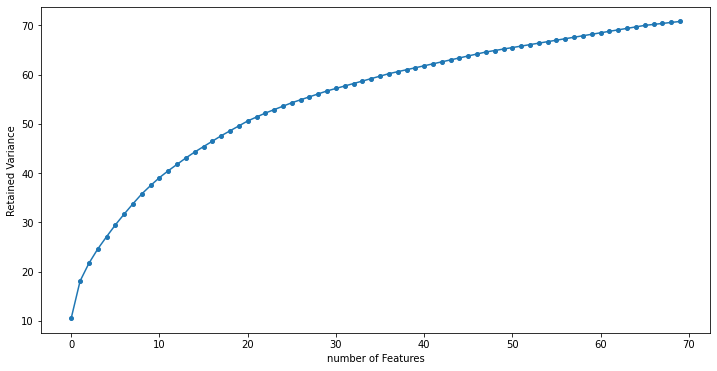

In [60]:
fig = plt.figure(figsize=(12,6))
plt.plot(var, marker=".", markersize=8)
plt.ylabel('Retained Variance')
plt.xlabel('number of Features')
plt.show()

### Complete the reduced dataset with useful informations
We add back some important features, such as `track_duration` and `track_language_code` which we believe will be useful for further analysis

In [61]:
# this is the final reduced dataset we will use for the K-means 
final_df_pca = pd.concat([
                    dataset.loc[:, [
                            'track_id',
                            'track_genre_top', 
                            'track_duration',
                            'audio_features_tempo',
                            'track_language_code',
                            'metadata_artist_location',
                            'audio_features_acousticness',
                            'audio_features_danceability',
                            'audio_features_energy',
                            'audio_features_instrumentalness',
                            'audio_features_liveness',
                            'audio_features_speechiness'
                            ]
                    ],
                    final_df_pca],
                    axis = 1
                    )

In [62]:
print(final_df_pca.shape)
final_df_pca.head()

(13129, 82)


,track_id,track_genre_top,track_duration,audio_features_tempo,track_language_code,metadata_artist_location,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69
0,2,Hip-Hop,168,165.922,en,"Georgia, US",0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,3.072119,-2.813221,-5.725668,4.304132,3.132022,2.035440,6.762814,-0.911985,-2.241416,4.289450,-4.922346,1.591437,-4.127119,5.366357,-0.418826,2.156308,-1.021449,-0.885456,1.858664,0.471522,-2.180434,-0.666800,-2.008849,1.657796,0.323524,-3.121823,-0.582617,0.477295,3.375484,-1.054536,0.631447,1.364209,0.019399,-1.381248,-0.183418,0.876504,0.868720,-1.519634,3.055780,-0.406429,0.141762,-3.413881,0.158314,-1.296973,-0.631775,-1.301991,0.879866,2.289361,1.309291,-0.732240,0.809130,0.150777,1.261749,-0.040736,-1.524833,-0.880712,-1.639447,-0.116741,-0.235137,-0.651479,-2.199347,0.752734,0.833377,0.088318,0.927609,0.389138,0.317811,-0.641747,0.087874,-0.306678
1,3,Hip-Hop,237,126.957,en,"Georgia, US",0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,5.772561,-5.407181,-5.294061,-1.584266,-3.638395,2.654533,-1.537542,5.905883,-0.147142,4.196322,-2.232328,2.496246,-0.802963,3.845890,1.908553,1.201517,-2.027632,-3.927108,0.030639,1.718998,0.458588,-1.333962,-0.105748,3.662689,0.411962,-1.220433,0.989977,-0.739263,1.316735,-0.935997,1.707657,0.584221,-0.540954,-0.463644,-1.199781,1.782897,-1.558571,-0.742920,2.120738,3.094388,-2.194779,-0.418205,-0.814308,-0.880816,-1.421191,-2.758551,1.798212,0.029270,0.966376,0.213901,-1.423308,-0.436824,0.664666,-0.804811,-0.126009,-2.558758,-1.167925,0.091903,-1.238039,-0.270714,-0.415459,-0.370817,0.530109,-0.588128,1.321617,-0.548403,-0.155986,0.245963,-1.476685,1.057215
2,5,Hip-Hop,206,100.260,en,"Georgia, US",0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,2.649641,-4.158976,-4.567940,-0.047132,-2.858061,2.094867,-1.279897,-0.327407,-0.115413,1.768117,-2.125721,3.173056,-3.124092,2.647477,0.097051,2.158555,-0.692991,-3.070376,2.254979,-1.802855,-2.939126,-1.284946,2.110134,2.939396,-0.549716,-2.196504,1.220935,-0.531148,0.253878,-0.874533,0.982520,-2.527932,1.397752,-0.746457,1.847429,-0.318288,0.145770,-1.600376,1.050530,2.531595,-1.355892,-1.505836,-0.083189,-0.862762,-0.887738,1.131726,1.050763,0.842503,-0.474756,-1.849124,0.737532,-0.466404,2.471529,-1.416131,-2.087690,-2.746890,-1.430543,-2.297307,0.641391,0.085349,-1.280372,-1.257064,1.136452,-1.660398,-1.166402,0.516734,-0.403789,-0.363024,0.168949,2.003296
3,10,Pop,161,111.562,en,"Philadelphia, PA, US",0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,9.115670,3.774618,-5.525645,0.761816,-1.352966,0.598744,-1.806204,4.104496,-0.543390,4.885488,-1.975667,6.558287,1.826454,0.000408,-1.482159,-4.445160,0.006109,-2.864430,2.662812,-1.971283,-2.381675,4.235330,-2.302619,0.090118,2.357771,-1.925538,-1.395706,0.907721,-0.382035,5.491218,-1.060498,4.300053,1.953275,4.245409,3.511838,0.108911,-5.528486,-2.372455,0.261941,1.286052,-0.261019,-2.171099,0.499492,0.472658,-1.856357,-1.366843,1.393731,0.736369,-1.678914,-3.209897,0.216900,2.274608,0.075130,1.252053,0.643083,-0.263949,-0.303804,0.997509,-0.946655,-0.178919,-1.164605,0.66

## 2.3 Clustering

We will now implement the *K-means clustering algorithm* (not ++: random initialization) from scratch. Then we will find an optimal number of clusters, running the algorithm on the data from the previous dimensionality reduction. At the end we will use the already implemented version of k-means++ (from the `scikit-learn` library) to compare the results.

In [65]:
# for kmeans_utils the module "kneed" needs to be installed
import kmeans_utils as kmu
from sklearn.cluster import KMeans

In [66]:
del tracks; del echonest; del features 

In [67]:
df_pca = final_df_pca.iloc[:, 12:]
df_pca.head()

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69
0,3.072119,-2.813221,-5.725668,4.304132,3.132022,2.035440,6.762814,-0.911985,-2.241416,4.289450,-4.922346,1.591437,-4.127119,5.366357,-0.418826,2.156308,-1.021449,-0.885456,1.858664,0.471522,-2.180434,-0.666800,-2.008849,1.657796,0.323524,-3.121823,-0.582617,0.477295,3.375484,-1.054536,0.631447,1.364209,0.019399,-1.381248,-0.183418,0.876504,0.868720,-1.519634,3.055780,-0.406429,0.141762,-3.413881,0.158314,-1.296973,-0.631775,-1.301991,0.879866,2.289361,1.309291,-0.732240,0.809130,0.150777,1.261749,-0.040736,-1.524833,-0.880712,-1.639447,-0.116741,-0.235137,-0.651479,-2.199347,0.752734,0.833377,0.088318,0.927609,0.389138,0.317811,-0.641747,0.087874,-0.306678
1,5.772561,-5.407181,-5.294061,-1.584266,-3.638395,2.654533,-1.537542,5.905883,-0.147142,4.196322,-2.232328,2.496246,-0.802963,3.845890,1.908553,1.201517,-2.027632,-3.927108,0.030639,1.718998,0.458588,-1.333962,-0.105748,3.662689,0.411962,-1.220433,0.989977,-0.739263,1.316735,-0.935997,1.707657,0.584221,-0.540954,-0.463644,-1.199781,1.782897,-1.558571,-0.742920,2.120738,3.094388,-2.194779,-0.418205,-0.814308,-0.880816,-1.421191,-2.758551,1.798212,0.029270,0.966376,0.213901,-1.423308,-0.436824,0.664666,-0.804811,-0.126009,-2.558758,-1.167925,0.091903,-1.238039,-0.270714,-0.415459,-0.370817,0.530109,-0.588128,1.321617,-0.548403,-0.155986,0.245963,-1.476685,1.057215
2,2.649641,-4.158976,-4.567940,-0.047132,-2.858061,2.094867,-1.279897,-0.327407,-0.115413,1.768117,-2.125721,3.173056,-3.124092,2.647477,0.097051,2.158555,-0.692991,-3.070376,2.254979,-1.802855,-2.939126,-1.284946,2.110134,2.939396,-0.549716,-2.196504,1.220935,-0.531148,0.253878,-0.874533,0.982520,-2.527932,1.397752,-0.746457,1.847429,-0.318288,0.145770,-1.600376,1.050530,2.531595,-1.355892,-1.505836,-0.083189,-0.862762,-0.887738,1.131726,1.050763,0.842503,-0.474756,-1.849124,0.737532,-0.466404,2.471529,-1.416131,-2.087690,-2.746890,-1.430543,-2.297307,0.641391,0.085349,-1.280372,-1.257064,1.136452,-1.660398,-1.166402,0.516734,-0.403789,-0.363024,0.168949,2.003296
3,9.115670,3.774618,-5.525645,0.761816,-1.352966,0.598744,-1.806204,4.104496,-0.543390,4.885488,-1.975667,6.558287,1.826454,0.000408,-1.482159,-4.445160,0.006109,-2.864430,2.662812,-1.971283,-2.381675,4.235330,-2.302619,0.090118,2.357771,-1.925538,-1.395706,0.907721,-0.382035,5.491218,-1.060498,4.300053,1.953275,4.245409,3.511838,0.108911,-5.528486,-2.372455,0.261941,1.286052,-0.261019,-2.171099,0.499492,0.472658,-1.856357,-1.366843,1.393731,0.736369,-1.678914,-3.209897,0.216900,2.274608,0.075130,1.252053,0.643083,-0.263949,-0.303804,0.997509,-0.946655,-0.178919,-1.164605,0.661905,-0.694683,-1.053222,2.142534,0.014732,-1.902633,2.422163,-0.666289,1.923754
4,1.304113,-9.446307,-4.280819,0.727942,-3.844975,-1.236656,-2.937631,-2.198282,-0.519997,2.524127,-0.571457,1.422137,-1.259725,1.103723,-0.960878,1.950518,2.180632,-1.753235,1.130802,2.053756,0.080862,-2.421076,0.178947,0.203299,-1.055265,-2.936424,1.752632,0.032424,1.575963,1.431831,-0.644605,-0.031911,0.994839,-2.478709,0.831314,0.059904,0.206688,-1.083684,-0.915856,2.213286,0.532936,-1.598853,-0.368293,-0.512312,0.330484,-1.441935,0.486125,-0.079722,-0.615031,-0.831753,-0.006297,0.288853,-0.076870,0.855943,-0.370697,0.184810,-2.250909,0.007876,-2.547213,

Fitting: MyKM with k=1
Fitting: MyKM with k=2
Fitting: MyKM with k=3
Fitting: MyKM with k=4
Fitting: MyKM with k=5
Fitting: MyKM with k=6
Fitting: MyKM with k=7
Fitting: MyKM with k=8


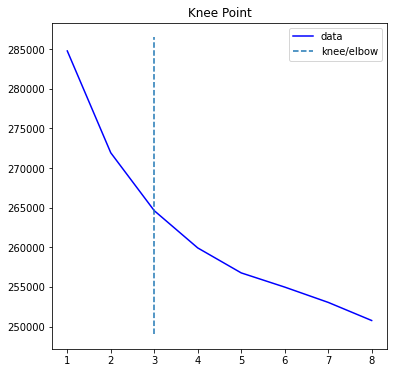

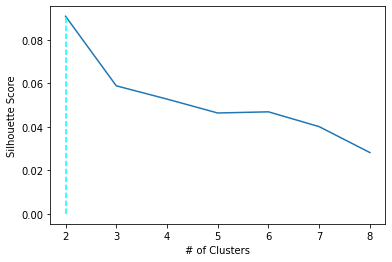

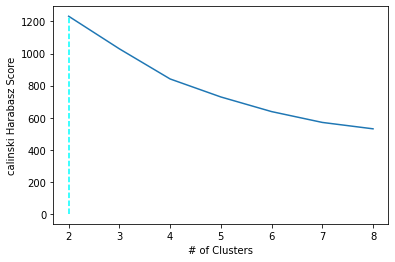

In [68]:
# REMARK: the execution of this cell can take a few seconds

k, score_results = kmu.get_best_k(kmu.MyKM, df_pca, max_k=8, seed=42)

In [69]:
print('Best k is:', k)

Best k is: 2


### Comparison between our Kmeans and Scikit-learn Kmeans++
**Initialization:** In our kmeans (MyKM) the number of clusters is provided in the fit method and not in the instance creation (i.e.: not imploemented in \__init\__)

In [70]:
# Initialization
my_km = kmu.MyKM(n_clusters=4, seed=42)
km = KMeans(n_clusters=4, random_state=42)

**Fitting:** Scikit-learn kmeans is faster than ours implementation. It takes less than 1s to train 10 models whereas our model takes about 10s for a fit.

In [71]:
my_km.fit(df_pca, info=True)


*** INFO: ***
n_clusters: 4
Elapsed time: 10.581141948699951
Stop Condtion: ['eps']
Inertia: 259918.75142058975


In [72]:
import time
t0 = time.time()
print(km.fit(df_pca), 'Computing time:', time.time() - t0)

KMeans(n_clusters=4, random_state=42) Computing time: 2.701939582824707


**Results:** The labels are different for the two algorithms. In order to compare them we will compare the value of inertia.
Our result seems to bu much better , in fact its about 40% than scikit-learn's kmeans:

In [73]:
print('my_km inertia:', my_km.inertia_)
print('km inertia:', km.inertia_)

my_km inertia: 259918.75142058975
km inertia: 5885638.143006828


Saving the model for further analysis

In [74]:
kmu.save_model(my_km)

## 2.4 Analysing the results



Load the model:

In [75]:
my_km = kmu.load_model()

Adding the computed labels to the dataset

In [76]:
final_df_pca['labels'] = my_km.labels_

Check the dataset head

In [77]:
final_df_pca.head()

,track_id,track_genre_top,track_duration,audio_features_tempo,track_language_code,metadata_artist_location,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_15,Feature_16,Feature_17,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,Feature_28,Feature_29,Feature_30,Feature_31,Feature_32,Feature_33,Feature_34,Feature_35,Feature_36,Feature_37,Feature_38,Feature_39,Feature_40,Feature_41,Feature_42,Feature_43,Feature_44,Feature_45,Feature_46,Feature_47,Feature_48,Feature_49,Feature_50,Feature_51,Feature_52,Feature_53,Feature_54,Feature_55,Feature_56,Feature_57,Feature_58,Feature_59,Feature_60,Feature_61,Feature_62,Feature_63,Feature_64,Feature_65,Feature_66,Feature_67,Feature_68,Feature_69,labels
0,2,Hip-Hop,168,165.922,en,"Georgia, US",0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,3.072119,-2.813221,-5.725668,4.304132,3.132022,2.035440,6.762814,-0.911985,-2.241416,4.289450,-4.922346,1.591437,-4.127119,5.366357,-0.418826,2.156308,-1.021449,-0.885456,1.858664,0.471522,-2.180434,-0.666800,-2.008849,1.657796,0.323524,-3.121823,-0.582617,0.477295,3.375484,-1.054536,0.631447,1.364209,0.019399,-1.381248,-0.183418,0.876504,0.868720,-1.519634,3.055780,-0.406429,0.141762,-3.413881,0.158314,-1.296973,-0.631775,-1.301991,0.879866,2.289361,1.309291,-0.732240,0.809130,0.150777,1.261749,-0.040736,-1.524833,-0.880712,-1.639447,-0.116741,-0.235137,-0.651479,-2.199347,0.752734,0.833377,0.088318,0.927609,0.389138,0.317811,-0.641747,0.087874,-0.306678,1
1,3,Hip-Hop,237,126.957,en,"Georgia, US",0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,5.772561,-5.407181,-5.294061,-1.584266,-3.638395,2.654533,-1.537542,5.905883,-0.147142,4.196322,-2.232328,2.496246,-0.802963,3.845890,1.908553,1.201517,-2.027632,-3.927108,0.030639,1.718998,0.458588,-1.333962,-0.105748,3.662689,0.411962,-1.220433,0.989977,-0.739263,1.316735,-0.935997,1.707657,0.584221,-0.540954,-0.463644,-1.199781,1.782897,-1.558571,-0.742920,2.120738,3.094388,-2.194779,-0.418205,-0.814308,-0.880816,-1.421191,-2.758551,1.798212,0.029270,0.966376,0.213901,-1.423308,-0.436824,0.664666,-0.804811,-0.126009,-2.558758,-1.167925,0.091903,-1.238039,-0.270714,-0.415459,-0.370817,0.530109,-0.588128,1.321617,-0.548403,-0.155986,0.245963,-1.476685,1.057215,1
2,5,Hip-Hop,206,100.260,en,"Georgia, US",0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,2.649641,-4.158976,-4.567940,-0.047132,-2.858061,2.094867,-1.279897,-0.327407,-0.115413,1.768117,-2.125721,3.173056,-3.124092,2.647477,0.097051,2.158555,-0.692991,-3.070376,2.254979,-1.802855,-2.939126,-1.284946,2.110134,2.939396,-0.549716,-2.196504,1.220935,-0.531148,0.253878,-0.874533,0.982520,-2.527932,1.397752,-0.746457,1.847429,-0.318288,0.145770,-1.600376,1.050530,2.531595,-1.355892,-1.505836,-0.083189,-0.862762,-0.887738,1.131726,1.050763,0.842503,-0.474756,-1.849124,0.737532,-0.466404,2.471529,-1.416131,-2.087690,-2.746890,-1.430543,-2.297307,0.641391,0.085349,-1.280372,-1.257064,1.136452,-1.660398,-1.166402,0.516734,-0.403789,-0.363024,0.168949,2.003296,1
3,10,Pop,161,111.562,en,"Philadelphia, PA, US",0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,9.115670,3.774618,-5.525645,0.761816,-1.352966,0.598744,-1.806204,4.104496,-0.543390,4.885488,-1.975667,6.558287,1.826454,0.000408,-1.482159,-4.445160,0.006109,-2.864430,2.662812,-1.971283,-2.381675,4.235330,-2.302619,0.090118,2.357771,-1.925538,-1.395706,0.907721,-0.382035,5.491218,-1.060498,4.300053,1.953275,4.245409,3.511838,0.108911,-5.528486,-2.372455,0.261941,1.286052,-0.261019,-2.171099,0.499492,0.472658,-1.856357,-1.366843,1.393731,0.736369,-1.678914,-3.209897,0.216900,2.274608,0.075130,1.252053,0.643083,-0.263949,-0.303804,0.997509,-0.946655,-0.178919,-

**1. Language**

In [78]:
kmu.get_crosstab('track_language_code', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_language_code,,,,
,62.8,58.9,53.4,52.5
ar,0.0,0.0,0.0,0.1
bm,0.0,0.0,0.0,0.0
cs,0.0,0.0,0.0,0.0
de,0.0,0.0,0.0,0.0
el,0.0,0.0,0.1,0.0
en,35.1,38.3,45.0,46.4
es,1.2,1.4,0.8,0.2
fi,0.0,0.0,0.0,0.1


**2. Track duration**

In [79]:
kmu.get_crosstab('track_duration', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_duration,,,,
"(17.999, 156.0]",23.7,17.3,36.2,22.0
"(156.0, 214.0]",26.4,22.1,26.5,27.0
"(214.0, 282.0]",28.4,29.3,20.2,23.7
"(282.0, 3033.0]",21.4,31.3,17.2,27.3
Total,100.0,100.0,100.0,100.0


**3. Tempo** 

In [80]:
kmu.get_crosstab('audio_features_tempo', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_tempo,,,,
"(12.752, 95.967]",18.7,27.6,17.9,31.8
"(95.967, 120.057]",22.2,25.8,22.1,28.1
"(120.057, 145.318]",30.0,23.2,27.3,22.9
"(145.318, 251.072]",29.1,23.4,32.7,17.2
Total,100.0,100.0,100.0,100.0


**4. Acousticness**

In [81]:
kmu.get_crosstab('audio_features_acousticness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_acousticness,,,,
"(-0.000999096, 0.104]",54.3,30.9,30.9,3.7
"(0.104, 0.574]",32.8,35.3,26.1,10.7
"(0.574, 0.921]",11.6,25.1,28.0,25.7
"(0.921, 0.996]",1.4,8.7,15.0,59.8
Total,100.0,100.0,100.0,100.0


**5. Danceability**

In [82]:
kmu.get_crosstab('audio_features_danceability', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_danceability,,,,
"(0.0503, 0.345]",15.2,7.3,40.3,30.2
"(0.345, 0.486]",23.0,15.1,28.0,32.7
"(0.486, 0.629]",29.8,27.2,20.1,26.4
"(0.629, 0.969]",32.0,50.4,11.5,10.7
Total,100.0,100.0,100.0,100.0


**6. Energy**

In [83]:
kmu.get_crosstab('audio_features_energy', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_energy,,,,
"(-0.0009798, 0.321]",1.7,17.7,4.7,61.3
"(0.321, 0.549]",11.7,35.7,15.2,28.2
"(0.549, 0.776]",27.0,32.4,32.1,9.1
"(0.776, 1.0]",59.7,14.2,47.9,1.4
Total,100.0,100.0,100.0,100.0


**7. Instrumentalness**

In [84]:
kmu.get_crosstab('audio_features_instrumentalness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_instrumentalness,,,,
"(-0.001, 0.323]",27.7,32.4,18.4,23.5
"(0.323, 0.838]",35.1,25.2,26.8,19.8
"(0.838, 0.918]",24.2,27.6,26.5,20.9
"(0.918, 0.998]",13.0,14.8,28.3,35.8
Total,100.0,100.0,100.0,100.0


**8. Liveness**

In [85]:
kmu.get_crosstab('audio_features_liveness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_liveness,,,,
"(0.0243, 0.101]",30.4,31.0,21.5,20.8
"(0.101, 0.119]",13.0,25.9,21.0,31.9
"(0.119, 0.211]",23.2,22.4,29.0,24.0
"(0.211, 0.98]",33.4,20.6,28.5,23.3
Total,100.0,100.0,100.0,100.0


**9. Speechiness**

In [86]:
kmu.get_crosstab('audio_features_speechiness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_speechiness,,,,
"(0.0213, 0.0369]",17.2,12.6,23.8,41.6
"(0.0369, 0.049]",21.7,17.2,26.8,32.2
"(0.049, 0.0855]",28.9,26.1,30.5,16.8
"(0.0855, 0.966]",32.3,44.1,18.8,9.4
Total,100.0,100.0,100.0,100.0


### Genre

In [87]:
kmu.get_crosstab('track_genre_top', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_genre_top,,,,
,29.6,35.7,20.7,29.7
Blues,0.0,0.3,0.4,1.0
Classical,0.3,0.1,0.1,6.5
Electronic,41.9,27.1,8.3,6.5
Experimental,0.2,0.1,0.1,0.2
Folk,0.7,1.9,2.5,17.8
Hip-Hop,6.1,15.2,4.8,0.8
Instrumental,0.0,0.5,0.5,1.1
International,0.3,0.6,0.7,2.0


###  KMeans++ Analysis
Replacing the  MyKM labels with the ones provided by scikit-learn KMeans++

Fitting: KMeans(n_clusters=1, random_state=42) with k=1
Fitting: KMeans(n_clusters=2, random_state=42) with k=2
Fitting: KMeans(n_clusters=3, random_state=42) with k=3
Fitting: KMeans(n_clusters=4, random_state=42) with k=4
Fitting: KMeans(n_clusters=5, random_state=42) with k=5
Fitting: KMeans(n_clusters=6, random_state=42) with k=6
Fitting: KMeans(n_clusters=7, random_state=42) with k=7
Fitting: KMeans(random_state=42) with k=8


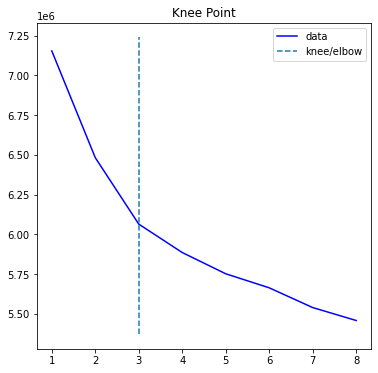

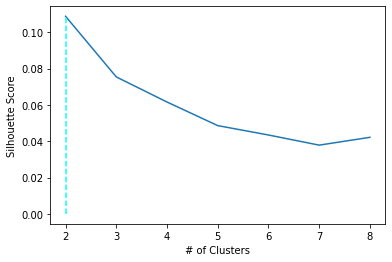

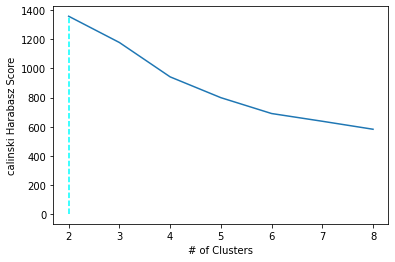

In [88]:
best_k, score_results = kmu.get_best_k(KMeans, df_pca, max_k=8, random_state=42)

In [89]:
km_opt = KMeans(n_clusters=4, random_state=42).fit(df_pca)

In [90]:
final_df_pca['labels'] = km_opt.labels_

**1. Language**

In [91]:
kmu.get_crosstab('track_language_code', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_language_code,,,,
,54.0,57.9,58.0,48.1
ar,0.0,0.0,0.0,0.1
bm,0.0,0.0,0.0,0.0
cs,0.0,0.0,0.0,0.0
de,0.0,0.0,0.1,0.0
el,0.1,0.0,0.0,0.0
en,44.4,39.3,40.3,51.0
es,0.9,1.5,0.5,0.2
fi,0.0,0.0,0.0,0.2


**2. Track duration**

In [92]:
kmu.get_crosstab('track_duration', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_duration,,,,
"(17.999, 156.0]",37.1,19.3,17.2,28.2
"(156.0, 214.0]",27.0,22.4,24.7,29.4
"(214.0, 282.0]",19.5,28.3,29.0,18.9
"(282.0, 3033.0]",16.5,30.0,29.1,23.5
Total,100.0,100.0,100.0,100.0


**3. Tempo** 

In [93]:
kmu.get_crosstab('audio_features_tempo', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_tempo,,,,
"(12.752, 95.967]",17.6,26.6,25.5,39.5
"(95.967, 120.057]",21.9,24.4,28.0,26.6
"(120.057, 145.318]",27.0,24.2,25.9,19.2
"(145.318, 251.072]",33.5,24.8,20.7,14.7
Total,100.0,100.0,100.0,100.0


**4. Acousticness**

In [94]:
kmu.get_crosstab('audio_features_acousticness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_acousticness,,,,
"(-0.000999096, 0.104]",34.1,39.2,12.5,0.2
"(0.104, 0.574]",26.0,34.0,24.9,1.1
"(0.574, 0.921]",25.7,20.4,35.0,7.6
"(0.921, 0.996]",14.1,6.4,27.6,91.1
Total,100.0,100.0,100.0,100.0


**5. Danceability**

In [95]:
kmu.get_crosstab('audio_features_danceability', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_danceability,,,,
"(0.0503, 0.345]",40.5,5.4,22.4,37.6
"(0.345, 0.486]",28.0,13.4,29.4,33.0
"(0.486, 0.629]",20.2,25.5,31.0,20.6
"(0.629, 0.969]",11.3,55.7,17.1,8.8
Total,100.0,100.0,100.0,100.0


**6. Energy**

In [96]:
kmu.get_crosstab('audio_features_energy', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_energy,,,,
"(-0.0009798, 0.321]",4.7,11.9,32.8,89.1
"(0.321, 0.549]",12.1,30.4,39.0,9.2
"(0.549, 0.776]",29.0,33.6,22.2,1.5
"(0.776, 1.0]",54.2,24.1,6.0,0.2
Total,100.0,100.0,100.0,100.0


**7. Instrumentalness**

In [97]:
kmu.get_crosstab('audio_features_instrumentalness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_instrumentalness,,,,
"(-0.001, 0.323]",18.3,32.7,26.5,20.6
"(0.323, 0.838]",28.1,26.5,24.3,15.4
"(0.838, 0.918]",25.9,27.3,24.7,17.9
"(0.918, 0.998]",27.8,13.5,24.5,46.1
Total,100.0,100.0,100.0,100.0


**8. Liveness**

In [98]:
kmu.get_crosstab('audio_features_liveness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_liveness,,,,
"(0.0243, 0.101]",21.7,32.2,23.4,21.0
"(0.101, 0.119]",19.3,22.0,33.3,25.2
"(0.119, 0.211]",28.6,22.0,25.1,22.5
"(0.211, 0.98]",30.4,23.8,18.3,31.2
Total,100.0,100.0,100.0,100.0


**9. Speechiness**

In [99]:
kmu.get_crosstab('audio_features_speechiness', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
audio_features_speechiness,,,,
"(0.0213, 0.0369]",21.0,6.7,46.1,23.3
"(0.0369, 0.049]",27.2,13.8,28.0,38.0
"(0.049, 0.0855]",32.0,27.0,17.1,22.8
"(0.0855, 0.966]",19.8,52.5,8.8,16.0
Total,100.0,100.0,100.0,100.0


 **10. Genre**

In [100]:
kmu.get_crosstab('track_genre_top', final_df_pca)

,Cluster # 1,Cluster # 2,Cluster # 3,Cluster # 4
track_genre_top,,,,
,20.9,33.1,33.5,26.4
Blues,0.2,0.3,0.9,0.6
Classical,0.1,0.1,0.6,15.2
Electronic,11.6,34.3,9.1,6.9
Experimental,0.2,0.1,0.1,0.3
Folk,2.3,0.6,13.2,15.2
Hip-Hop,4.1,18.0,2.2,0.5
Instrumental,0.4,0.4,1.0,0.7
International,0.8,0.6,1.5,1.4


# 3. Algorithmic questions

Given a list of integers, A, and another integer s. Write an algorithm that outputs all the pairs in A that equal x.

*Example* . If $A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]$ and $s = 4$, then the algorithm should output: $(7, -3), (-2, 6), (2, 2), (3, 1)$.

A **simple solution** is to inspect each element of the list and check if there’s another number in the array which can be added to it to give sum. The simple solution has complexity $O(n^2)$ wich can be improved (e.g. by sorting the array first and than using binary search). A **second and more efficient solution** is given using Hash Tables: 
- Consider a Hash Table H 
- For each element $A[i]$ check if $s-A[i]$ is in $H$ 

The time complexity in this case is $O(n)$. 

In [101]:
# the following code is shorter then the simple solution
# but the complezity is O(n!)
from itertools import combinations
def algo1(A, s):
    a = combinations(A, 2)
    return list(filter(lambda x: sum(x) == s, a ))

In [102]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3] 
s = 4

In [103]:
algo1(A, s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [104]:
# simple solution using an upper triangular matrix
# complexity of O(n^2)
def algo2(A,s) :
    l=[]
    for i in range (len(A)-1):
        for j in range (i + 1, len(A)):
            if (A[i] + A[j] == s):
                l.append((A[i] , A[j]))
    return(l)

In [105]:
algo2(A,s)

[(7, -3), (-2, 6), (2, 2), (1, 3)]

In [106]:
# efficient solution with Hash tables
# complexity O(n)
def algo3(A,s):
    count = 0
    # the set X will work as an Hash Table for the list A
    X = set(A)
    # list to keep track of all the pairs with sum s
    couples = []
    
    for item in A:
        if s - item in X:
            # min and max are used to discard duplicates
            couples.append ((min(item, s-item), max(item, s-item)))
            count+=1
    set_pairs = set(couples)
    print ("Pairs which sum up to ",s," are: ", set_pairs)


In [107]:
algo3(A,s)

Pairs which sum up to  4  are:  {(-2, 6), (1, 3), (2, 2), (-3, 7)}
